Smile or non smile classification using transfer learning

Table of contents

1.0 Import Packages

2.0 Show Number of Images Per Label


3.0 Show Sample Images of Each Label

4.0 Image Data Generator, Split Data for Training and Validation 

5.0 Modelling Neural Network by using a pretrained model

6.0 Use our model to make predictions

In [1]:
import os
import numpy
import random
import pandas as pd 
import numpy as np 
import shutil
from shutil import copyfile
import tensorflow as tf 
from tensorflow.keras.preprocessing.image import ImageDataGenerator 
from tensorflow.keras import Model
import matplotlib.pyplot as plt 
import matplotlib.image as mpimg 
from matplotlib.offsetbox import (TextArea, DrawingArea, OffsetImage, AnnotationBbox)
import matplotlib.patches as mpatches

Uplaoding our folder from a local directory.

In [3]:
# assigning a path to our directory
base_dr = r'../tochora/data smile/'


we are going to make a dataframe having classifieed images in the folder into two groups that is  smile and non-smile and number of images in each group.The dataframe will consist of columns: Tran-test made up of two folders in our dataset that is test and train, labels which consist of smile and non smiles images and finally number of items which has the entries of either smile or non-smile images.

In [4]:
#creating empty lists 
mytrain_test_list = []
mylabels_list = []
myitem_list = []
vis_images =[]; vis_labels = []
#returning a list of images contained in the base directory
train_test_list = tf.io.gfile.listdir(base_dr)
# iterating each image in the train-test-list
for train_test in train_test_list:
    #concatenating base directory with images in train_test_list
    path1 = os.path.join(base_dr, train_test)
    # returning s list of iamges that are going act as labels in our dataset
    label_list = tf.io.gfile.listdir(path1)
    #iterating each label in the directory label_list
    for label in label_list:
        #concatenating images in path1 with each label in label_list
        my_path = os.path.join(path1, label)
        #getting a list of files in my_path directory
        item_files = os.listdir(my_path)
        
        mytrain_test_list.append(train_test)
        mylabels_list.append(label)
        myitem_list.append(len(item_files))

        my_files = item_files[0:5]
        for file in my_files:
            #getting each image fromm a respective label
            vis_images.append(os.path.join(my_path, file))
            #get a respective label for each image
            vis_labels.append(label)
#creating a dataframe to show various folders, assighned labels and entries in each label
pd.DataFrame({'Tran_test': mytrain_test_list, 'Labels': mylabels_list, 'Number of items': myitem_list})

,Tran_test,Labels,Number of items
0,test,non_smile,132
1,test,smile,132
2,train,non_smile,468
3,train,smile,468


Visualizing images in each label from our dataset

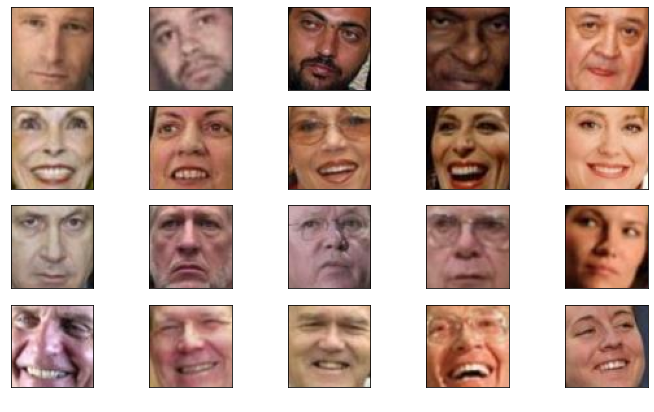

In [11]:
# specifying size of our figure
plt.figure(figsize=(12, 7))
# iterating by the number of items in the list vis_labels
for i in range(len(vis_labels)):
    #dividing the figure into a layou of 4 by 5
    plt.subplot(4, 5, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    # 
    img = mpimg.imread(vis_images[i])
    plt.imshow(img)
    plt.xlabel(vis_labels[i], fontdict={"color": "white"})
plt.show()

Augmenting our images with imageDatagenerator

we are going to use it to augment images that we have for training .It applies various transformations to our images such scaling, angle changes and verticla shifting.this helps to generate multiple images from an image when one has a dataset that contains small number of images for training a model.This library is helpful especially when one has a small dataset.

In [8]:
# a function that generate multiple images
def show_imageDatagenerator(vis_images, vis_labels, image_index):
    class_label = vis_labels[image_index]
    #loading our image
    img = tf.keras.preprocessing.image.load_img(vis_images[image_index], target_size=(250, 250))
    # converting our image into an array vector
    img_tensor = tf.keras.preprocessing.image.img_to_array(img)
    img_tensor = np.expand_dims(img_tensor,axis=0)

    def show_image(datagen, param):
        pic = datagen.flow(img_tensor, batch_size=1)
        plt.figure(figsize=(10,4.5))
        for i in range(1,4):
            plt.subplot(1,3, i)
            batch = pic.next()
            image_ =batch[0].astype('uint8')
            plt.imshow(image_)
        plt.suptitle(f'class : {class_label} ' "\n image generator: {param}")
        plt.show()
    datagen = ImageDataGenerator(rotation_range=30)
    show_image(datagen, "rotation_range=30")
    datagen = ImageDataGenerator(width_shift_range=0.2)
    show_image(datagen, "width_shift_range=0.2")
    datagen = ImageDataGenerator(zoom_range=0.2)
    show_image(datagen, 'zoom_range=0.2')
    datagen =ImageDataGenerator(horizontal_flip=True)
    show_image(datagen, 'horizontal_flip=True')





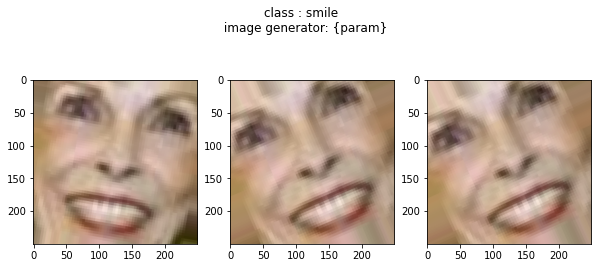

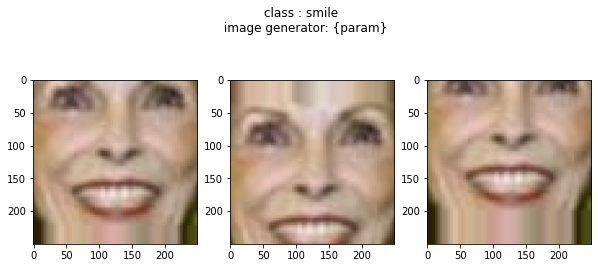

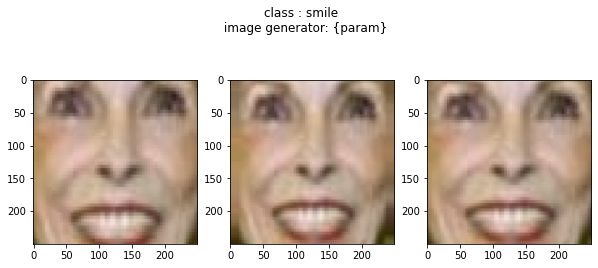

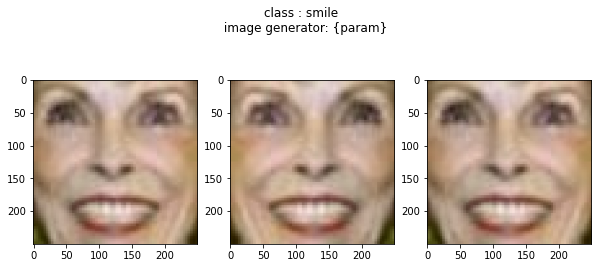

In [9]:
# using our function to generate images of the same image
show_imageDatagenerator(vis_images, vis_labels, image_index=5)

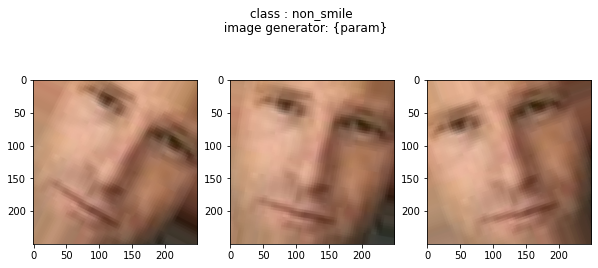

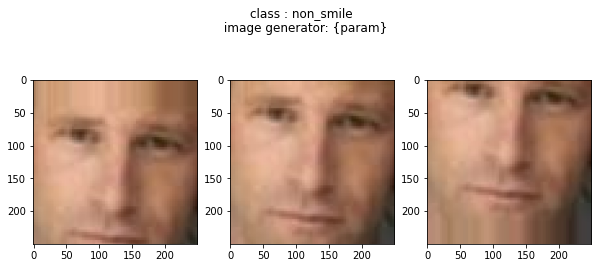

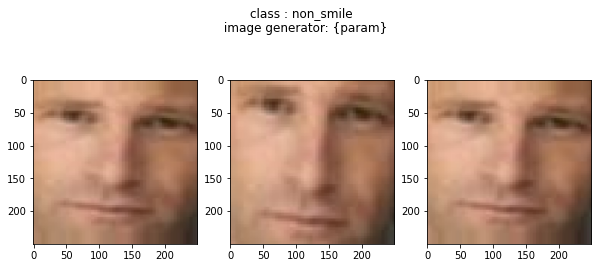

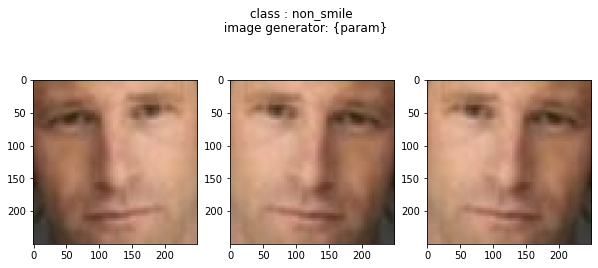

In [8]:
# choosing another image to augement it
show_imageDatagenerator(vis_images, vis_labels, image_index=0)

The above images show how imageDataGenerator can be used to augment images and also to make various alterations on them.


Here, we are going to use imageDataGenerator to make various transformations to our images by using parameters such as rotations , rescaling, vertical shifting etc so as get image vectors for maximum feature extraction  .Flow from directory will help in assgning directory path and generating image batches.


In [9]:
# afunction that splits our dataset into training and validation data
def train_val_generators(Training_dir, Validation_dir):
    # applying various transformations
    train_datagen = ImageDataGenerator(rescale=1./255, rotation_range=30, width_shift_range=0.2, zoom_range=0.2, height_shift_range=0.2, shear_range=0.2,
    horizontal_flip=True, fill_mode='nearest')
    #passing directory path
    train_generator = train_datagen.flow_from_directory(directory=Training_dir, batch_size=32, class_mode='binary', target_size=(150,150))
    validation_datagen = ImageDataGenerator(rescale=1./255)
    validation_generator = validation_datagen.flow_from_directory(directory=Validation_dir, batch_size=32, class_mode='binary', target_size=(150, 150))
    return train_generator, validation_generator


In [10]:
# assigning  training dir and validation dir a path
training_dir = os.path.join(base_dr, 'train')
validation_dir = os.path.join(base_dr, 'test')
print(validation_dir)

../tochora/data smile/test


In [11]:
#
train_generator, validation_generator = train_val_generators(training_dir, validation_dir)

Found 936 images belonging to 2 classes.
Found 264 images belonging to 2 classes.


Training data has 936 images from both smile and non smile classes while validation data has 264 images from the smae classes.

Transfer Learning

weare going to use a prettrained model MobileNetV2 which was trained on a big dataset since our dataset is small and only a pretrained model can have better accuracy so as to facilitate predictions.

we will set base_model parameters like weights to be the same with those of imagenet, setting include_top false to avoid top layers of the model from being used.

In [12]:
# uploading our model 
base_model = tf.keras.applications.MobileNetV2(input_shape=(150, 150, 3), include_top=False, weights='imagenet')
# preventing the weights of the model from being updated before the model is trained
base_model.trainable=False
last_output = base_model.output
#checiing trainable parameters in the model
num_trainable_params = sum([w.shape.num_elements() for w in base_model.trainable_weights])
print(f'there are {num_trainable_params} : training parameters in this model')
print(f'pretrained model has : {type(base_model)}')


there are 0 : training parameters in this model
pretrained model has : <class 'keras.engine.functional.Functional'>


In [13]:
def transfer_learning(last_output,pre_trained_model):
    #flatten the output layer to one deimension
    x = tf.keras.layers.Flatten()(last_output)
    #adding a fully connected layer with 1224 hidden units while using relu activation function
    x = tf.keras.layers.Dense(1224, activation='relu')(x)
    # adding a dropout rate of 0.6 units
    x = tf.keras.layers.Dropout(0.6)(x)
    #add a sigmoid layer with the purpose of binary classsification
    x = tf.keras.layers.Dense(1, activation='sigmoid')(x)
    # incorporating our model into the model class
    model = Model(inputs=pre_trained_model.input, outputs=x)
    return model
#
model = transfer_learning(last_output, base_model)
#a summary  of our model
model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 75, 75, 32)   864         ['input_1[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 75, 75, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 75, 75, 32)   0           ['bn_Conv1[0][0]']           

In [17]:
model = transfer_learning(last_output, base_model)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

In [18]:
#defining a callback that will stop our model from training when accuracy reaches 95%
class myCallbcks(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('accuracy') > 0.95):
            self.model.stop_training = True
callbacks = myCallbcks()
#fitting our model
modelb = model.fit(train_generator, epochs=6, validation_data=validation_generator, callbacks=callbacks)

Epoch 1/6
30/30 [==============================] - 96s 3s/step - loss: 11.5125 - accuracy: 0.6378 - val_loss: 1.1769 - val_accuracy: 0.8636
Epoch 2/6
30/30 [==============================] - 56s 2s/step - loss: 3.7436 - accuracy: 0.7511 - val_loss: 1.8989 - val_accuracy: 0.7841
Epoch 3/6
30/30 [==============================] - 49s 2s/step - loss: 1.9524 - accuracy: 0.7821 - val_loss: 0.4409 - val_accuracy: 0.8788
Epoch 4/6
30/30 [==============================] - 50s 2s/step - loss: 0.9039 - accuracy: 0.7949 - val_loss: 0.7725 - val_accuracy: 0.7689
Epoch 5/6
30/30 [==============================] - 51s 2s/step - loss: 0.6137 - accuracy: 0.7799 - val_loss: 0.2688 - val_accuracy: 0.8939
Epoch 6/6
30/30 [==============================] - 51s 2s/step - loss: 0.4395 - accuracy: 0.8066 - val_loss: 0.2347 - val_accuracy: 0.8977


Visualizing  our model performance

<AxesSubplot:>

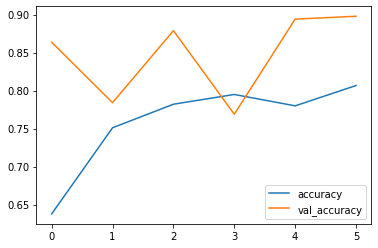

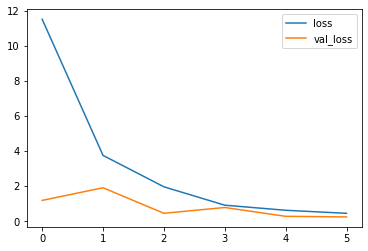

In [19]:
model_htm = pd.DataFrame(model.history.history)
model_htm[['accuracy', 'val_accuracy']].plot()
model_htm[['loss', 'val_loss']].plot()

In [20]:
vis_images[:5]

['../tochora/data smile/test\\non_smile\\Aaron_Eckhart_0001.jpg',
 '../tochora/data smile/test\\non_smile\\Aaron_Patterson_0001.jpg',
 '../tochora/data smile/test\\non_smile\\Abdel_Nasser_Assidi_0002.jpg',
 '../tochora/data smile/test\\non_smile\\Abdoulaye_Wade_0004.jpg',
 '../tochora/data smile/test\\non_smile\\Abdulaziz_Kamilov_0001.jpg']

the above figures shows that our model has performed well, we will use it to make predictions on any of the images gotten from the dataset that was used to train our model.
Below will be an implementation of predicting an image that has a non-smile person.

1/1 [==============================] - 0s 239ms/step
this image likely belongs to : non_smile


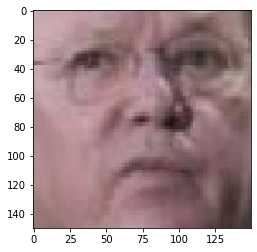

In [25]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image
def make_your_prediction(YOUR_IMAGE_PATH=None):
    if YOUR_IMAGE_PATH == None:
        YOUR_IMAGE_PATH = r'../tochora/gh.jpg'
    img = image.load_img(YOUR_IMAGE_PATH, target_size=(150, 150))
    plt.imshow(img)
    x = image.img_to_array(img)
    x /= 255
    x = np.expand_dims(x, axis=0)
    images = np.vstack([x])
    classes = model.predict(images, batch_size=10)
    score = tf.nn.sigmoid(classes[0])

    class_name = train_generator.class_indices
    class_name_inverted = {y: x for x, y in class_name.items()}
    if classes[0] > 0.5:
        print(f'this image likely belongs to : {class_name_inverted[1]}')
    else:
        print(f'this image likely belongs to : {class_name_inverted[0]}')
make_your_prediction(YOUR_IMAGE_PATH=None)


cool! it seem our model has performed well, let us now use it to predict an image where the person is smilling.

1/1 [==============================] - 0s 97ms/step
this image likely belongs to : smile


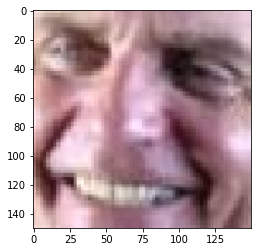

In [26]:
def make_your_prediction(YOUR_IMAGE_PATH=None):
    if YOUR_IMAGE_PATH == None:
        YOUR_IMAGE_PATH = r'../tochora/pro.jpg'
    img = image.load_img(YOUR_IMAGE_PATH, target_size=(150, 150))
    plt.imshow(img)
    x = image.img_to_array(img)
    x /= 255
    x = np.expand_dims(x, axis=0)
    images = np.vstack([x])
    classes = model.predict(images, batch_size=10)
    score = tf.nn.sigmoid(classes[0])

    class_name = train_generator.class_indices
    class_name_inverted = {y: x for x, y in class_name.items()}
    if classes[0] > 0.5:
        print(f'this image likely belongs to : {class_name_inverted[1]}')
    else:
        print(f'this image likely belongs to : {class_name_inverted[0]}')
make_your_prediction(YOUR_IMAGE_PATH=None)